In [28]:
DF_PATH = "../data/processed/preprocessed_df.pkl"
ROLE_COLS = ['DevType']
TECH_COLS = ['LanguageHaveWorkedWith','DatabaseHaveWorkedWith','PlatformHaveWorkedWith','WebframeHaveWorkedWith','MiscTechHaveWorkedWith','ToolsTechHaveWorkedWith','NEWCollabToolsHaveWorkedWith']
EXPORT_FEATURES_DIR = "../data/processed/"

In [29]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import multilabel_confusion_matrix
import os
import yaml

In [30]:
df = pd.read_pickle(DF_PATH)

In [31]:
#onehot encoding
encoded_dfs = {}
for col in ROLE_COLS + TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(
        binarizer.fit_transform(df[col]),
        columns=binarizer.classes_,
        index =df[col].index
    )
    encoded_dfs[col] = encoded_df 
ohe_df = pd.concat(encoded_dfs , axis=1)

##### Dimensionality Reduction

In [32]:
skills_ohe = ohe_df.drop('DevType' , axis=1).copy()
std_skills = StandardScaler().fit_transform(skills_ohe)

In [33]:
tsne_projection = TSNE(
  n_components= 2,
  perplexity= 3,
  learning_rate= 0.1,
  init= 'pca',
  method= 'barnes_hut',
  n_jobs=2,
  n_iter= 10**10,
  random_state=0
).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index= skills_ohe.columns)

In [34]:
tsne_projection.shape

(125, 2)

In [35]:
tsne_projection

0          1
LanguageHaveWorkedWith       APL                  4.325419  22.426392
                             Assembly           -26.741745  35.179596
                             Bash/Shell         -31.677191  17.574348
                             C                  -27.861040  36.858223
                             C#                  53.200951  11.250719
...                                                    ...        ...
NEWCollabToolsHaveWorkedWith Vim                -30.484169  17.161629
                             Visual Studio       50.689350  12.986851
                             Visual Studio Code  16.321482 -36.856899
                             Webstorm            32.860817 -22.739998
                             Xcode               -2.175342 -15.476834

[125 rows x 2 columns]

In [36]:
fig = px.scatter(x=tsne_projection[0] , y= tsne_projection[1] , text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition ='top center')
fig.update_layout(height = 1000 , width =1000 , title_text = 'TSNE')
fig.show()

#### Cluster

In [37]:
range_n_cluster = list(range(10,25))
silhouette_scores =[]
best_cluster_model =None

for n_clusters in range_n_cluster:
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters , linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)

    silhouette_avg = silhouette_score(tsne_projection ,cluster_labels)
    silhouette_scores += [silhouette_avg]

    if silhouette_avg >= np.max(silhouette_scores):
        best_cluster_model = cluster_model

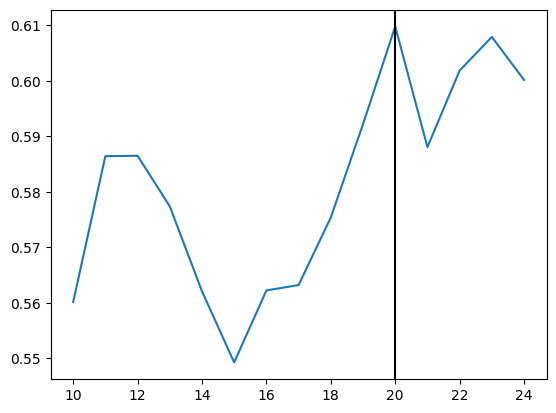

In [38]:
plt.plot(range_n_cluster , silhouette_scores)
plt.axvline(best_cluster_model.n_clusters_,color ='black')

In [39]:
cluster_labels =['skills_group_' + str(label)
                for label in best_cluster_model.labels_]

In [40]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [41]:
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)

In [42]:
for cluster , skills in skills_clusters.items():
    print(cluster)
    print(skills)

skills_group_0
['Go', 'DynamoDB', 'PostgreSQL', 'AWS', 'Ansible', 'Chef', 'Docker', 'Flow', 'Git', 'Kubernetes', 'Pulumi', 'Puppet', 'Terraform']
skills_group_1
['Scala', 'Cassandra', 'Couchbase', 'Elasticsearch', 'Redis', 'DigitalOcean', 'Apache Spark', 'Hadoop']
skills_group_10
['Dart', 'Kotlin', 'Firebase', 'SQLite', 'Google Cloud Platform', 'Flutter', 'Android Studio']
skills_group_11
['Assembly', 'C', 'C++', 'Qt']
skills_group_12
['Node.js', 'MongoDB', 'Heroku', 'Express', 'Gatsby', 'React.js', 'React Native', 'Yarn']
skills_group_13
['Unity 3D', 'Unreal Engine']
skills_group_14
['Ruby', 'Ruby on Rails', 'RubyMine', 'TextMate']
skills_group_15
['Svelte', 'Deno']
skills_group_16
['Bash/Shell', 'Perl', 'Vim']
skills_group_17
['Objective-C', 'Swift', 'Xcode']
skills_group_18
['TypeScript', 'Angular', 'Angular.js', 'Cordova']
skills_group_19
['Julia', 'R', 'RStudio']
skills_group_2
['APL', 'COBOL', 'Crystal', 'Delphi', 'Elixir', 'Erlang', 'IBM DB2', 'IBM Cloud or Watson']
skills_group

#### Create new features

In [43]:
new_features=[]

for cluster , skills in skills_clusters.items():
    cluster_sum = skills_ohe.droplevel(0 , axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features ,axis=1)

In [44]:
fe_clustered_skills

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,skills_group_18,skills_group_19,skills_group_2,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,1,0,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,4,2,0
1,3,0,1,0,1,0,0,0,0,0,2,0,0,0,1,1,3,1,1,0
2,0,0,1,2,1,0,0,0,0,0,0,2,0,5,1,0,3,0,1,1
3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0
4,4,4,0,0,1,0,0,0,2,0,0,0,0,3,1,2,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,3,0,2,0,0,0,0,0,1,0,0,0,0,0,3,1,0,0,1,1
83435,2,1,4,1,1,2,1,0,1,0,0,1,0,0,4,2,2,4,2,1
83436,7,3,2,0,1,0,0,0,1,1,0,0,0,4,5,1,4,0,1,0
83437,5,3,0,0,5,0,0,0,1,0,0,0,0,4,1,0,4,0,1,0


#### Illustration Model

In [45]:
#create train / test matrics
combined_features_df = pd.concat([fe_clustered_skills,skills_ohe.droplevel(0,axis=1)],axis=1)

In [46]:
roles_df = ohe_df['DevType'].copy()

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(combined_features_df, roles_df, test_size=0.3, random_state=0)

#### compute sample weight to deal with classes imbalance

In [48]:
#Assign class weight as an inverse of its freq
class_weight = (1/ roles_df.sum(axis=0))

# Multiply class weights with the 1 hot encoded values and get the mean of each sample
sample_weight = np.multiply(class_weight.values , Y_train.values).sum(axis=1)

In [49]:
def f1_from_confusion_matrix(confusion_matrix):
    return (confusion_matrix[1,1] / 
            (confusion_matrix[1,1] +
             (0.5 * (confusion_matrix[0,1] +confusion_matrix[1,0]))
             ))

In [50]:
feature_sets = {'original' : skills_ohe.droplevel(0,axis=1).columns.tolist(),
                'clusters': fe_clustered_skills.columns.tolist()}

In [51]:
feature_sets

{'original': ['APL',
  'Assembly',
  'Bash/Shell',
  'C',
  'C#',
  'C++',
  'COBOL',
  'Clojure',
  'Crystal',
  'Dart',
  'Delphi',
  'Elixir',
  'Erlang',
  'F#',
  'Go',
  'Groovy',
  'HTML/CSS',
  'Haskell',
  'Java',
  'JavaScript',
  'Julia',
  'Kotlin',
  'LISP',
  'Matlab',
  'Node.js',
  'Objective-C',
  'PHP',
  'Perl',
  'PowerShell',
  'Python',
  'R',
  'Ruby',
  'Rust',
  'SQL',
  'Scala',
  'Swift',
  'TypeScript',
  'VBA',
  'Cassandra',
  'Couchbase',
  'DynamoDB',
  'Elasticsearch',
  'Firebase',
  'IBM DB2',
  'MariaDB',
  'Microsoft SQL Server',
  'MongoDB',
  'MySQL',
  'Oracle',
  'PostgreSQL',
  'Redis',
  'SQLite',
  'AWS',
  'DigitalOcean',
  'Google Cloud Platform',
  'Heroku',
  'IBM Cloud or Watson',
  'Microsoft Azure',
  'Oracle Cloud Infrastructure',
  'ASP.NET',
  'ASP.NET Core ',
  'Angular',
  'Angular.js',
  'Django',
  'Drupal',
  'Express',
  'FastAPI',
  'Flask',
  'Gatsby',
  'Laravel',
  'React.js',
  'Ruby on Rails',
  'Spring',
  'Svelte',
  '

In [52]:
results = {}

for feature_set_name, feature_set in feature_sets.items():
    # Create sub trainings
    sub_train = X_train[feature_set].copy()
    sub_test  = X_test[feature_set].copy()
    
    # Train classifier 
    clf = MultiOutputClassifier(LogisticRegression())
    clf.fit(sub_train, Y_train, sample_weight=sample_weight)

    # Calcaulte F1 for training data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_train, clf.predict(sub_train))
    f1_train_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Calcaulte F1 for testing data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_test, clf.predict(sub_test))
    f1_test_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Add to results
    set_result = pd.DataFrame({"train": f1_train_scores, "test":f1_test_scores}, 
                              index=roles_df.columns.to_list())
    results[feature_set_name] = set_result.sort_values('test')
    
    
    # Print
    print("Feature set: " + feature_set_name)
    print(".. Mean train F1:", np.mean(f1_train_scores))    
    print(".. Mean test F1:", np.mean(f1_test_scores))
    print()

Feature set: original
.. Mean train F1: 0.12253898948743877
.. Mean test F1: 0.1224591824831881

Feature set: clusters
.. Mean train F1: 0.15835123028002615
.. Mean test F1: 0.15911818541739567



In [53]:
#Export new features
features_path = os.path.join(EXPORT_FEATURES_DIR ,"feature_skills_clusters.pkl")
fe_clustered_skills.to_pickle(features_path) 

In [54]:
description_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_description.yaml")
with open(description_path, 'w') as outfile:
    yaml.dump(skills_clusters.to_dict(), outfile)